In [84]:
import numpy as np
import qlib
from qlib.data import D
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 加载数据

In [2]:
qlib.init(provider_uri="~/.qlib/qlib_data/cn_data", region="cn")

[8272:MainThread](2025-08-29 13:49:35,795) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[8272:MainThread](2025-08-29 13:49:36,074) INFO - qlib.Initialization - [__init__.py:79] - qlib successfully initialized based on client settings.
[8272:MainThread](2025-08-29 13:49:36,074) INFO - qlib.Initialization - [__init__.py:81] - data_path={'__DEFAULT_FREQ': PosixPath('/Users/huhao/.qlib/qlib_data/cn_data')}


In [105]:
# 加载一段时间的数据
df_origin = D.features(
    instruments=["SH600000", "SZ000001"],
    fields=[
        "$close", "$volume",
        "Ref($close, -1)/$close - 1",       # 昨日收益率
        "Mean($close, 5)/$close - 1",       # 5日动量
        "Std($close, 10)",                  # 10日波动率
        "Mean($volume, 5)",                 # 5日均量
        "($high-$low)/$close",              # 日内波动率
    ],
    start_time="2018-01-01",
    end_time="2020-12-31",
    freq="day"                      # 日频
)

# D.features 返回的是一个 pandas.DataFrame
df_origin.tail()

$close      $volume  Ref($close, -1)/$close - 1  \
instrument datetime                                                        
SZ000001   2020-09-21  3.297979  426126592.0                   -0.015180   
           2020-09-22  3.247915  413580128.0                    0.004496   
           2020-09-23  3.262517  285060896.0                   -0.031969   
           2020-09-24  3.158217  501213952.0                    0.002642   
           2020-09-25  3.166561  291365728.0                         NaN   

                       Mean($close, 5)/$close - 1  Std($close, 10)  \
instrument datetime                                                  
SZ000001   2020-09-21                   -0.010626         0.062310   
           2020-09-22                    0.007450         0.062619   
           2020-09-23                    0.005627         0.061464   
           2020-09-24                    0.033554         0.065397   
           2020-09-25                    0.018972         0.060532   

                       Mean($volume, 5)  ($high-$low)/$close  
instrument datetime                                           
SZ000001   2020-09-21       435776320.0             0.021505  
           2020-09-22       456278720.0             0.028902  
           2020-09-23       444665696.0             0.020460  
           2020-09-24       450965344.0             0.032365  
           2020-09-25       383469472.0             0.013175

## 分离某个股票的数据

In [106]:
# 取出 SH600000 的数据
df = df_origin.loc["SH600000"]
df.head()

,$close,$volume,"Ref($close, -1)/$close - 1","Mean($close, 5)/$close - 1","Std($close, 10)","Mean($volume, 5)",($high-$low)/$close
datetime,,,,,,,
2018-01-02,9.063874,43957940.0,-0.004717,-0.007704,0.050386,33541552.0,0.013365
2018-01-03,9.021121,53102384.0,0.000000,-0.002686,0.043983,39888552.0,0.011058
2018-01-04,9.021121,39131384.0,0.002370,-0.002054,0.038476,38527820.0,0.008689
2018-01-05,9.042497,43542108.0,-0.000788,-0.002049,0.037563,40536308.0,0.007092
2018-01-08,9.035373,44051728.0,0.001577,0.000158,0.038804,44757108.0,0.006309


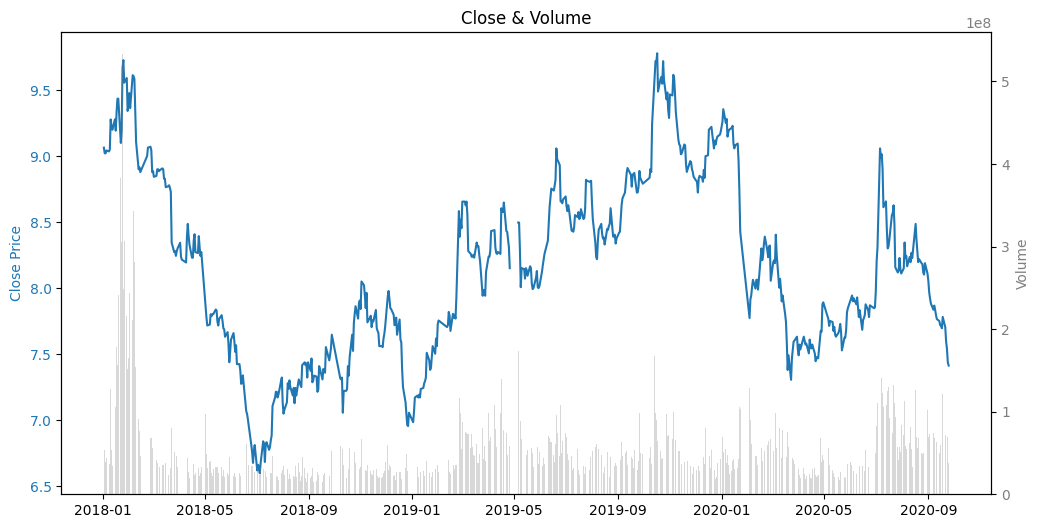

In [107]:
# 画收盘价和成交量
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_title("Close & Volume")
ax1.plot(df.index, df["$close"], color="tab:blue", label="Close Price")
ax1.set_ylabel("Close Price", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# 成交量放在副轴
ax2 = ax1.twinx()
ax2.bar(df.index, df["$volume"], alpha=0.3, color="tab:gray")
ax2.set_ylabel("Volume", color="tab:gray")
ax2.tick_params(axis="y", labelcolor="tab:gray")

plt.show()

## 是否未来一个月内下跌 10%

In [108]:
horizon = 20  # 未来20个交易日

# 方法1：倒序 + rolling（高效，适合大数据）
future_min_20d = df["$close"][::-1].rolling(window=horizon, min_periods=1).min()[::-1]
df["future_min_20d"] = future_min_20d

# 未来最大跌幅（相对于当天收盘价）
df["max_drop_pct_20d"] = (df["future_min_20d"] / df["$close"] - 1) * 100

# 是否未来20日下跌超过10%
df["drop_10pct_next_month"] = (df["max_drop_pct_20d"] <= -8).astype(int)

# 查看结果
df.head(25)

,$close,$volume,"Ref($close, -1)/$close - 1","Mean($close, 5)/$close - 1","Std($close, 10)","Mean($volume, 5)",($high-$low)/$close,future_min_20d,max_drop_pct_20d,drop_10pct_next_month
datetime,,,,,,,,,,
2018-01-02,9.063874,43957940.0,-0.004717,-0.007704,0.050386,33541552.0,0.013365,9.021121,-0.471688,0
2018-01-03,9.021121,53102384.0,0.000000,-0.002686,0.043983,39888552.0,0.011058,9.021121,0.000000,0
2018-01-04,9.021121,39131384.0,0.002370,-0.002054,0.038476,38527820.0,0.008689,9.021121,0.000000,0
2018-01-05,9.042497,43542108.0,-0.000788,-0.002049,0.037563,40536308.0,0.007092,9.035373,-0.078783,0
2018-01-08,9.035373,44051728.0,0.001577,0.000158,0.038804,44757108.0,0.006309,9.035373,0.000000,0
2018-01-09,9.049623,36790040.0,0.025197,-0.001732,0.038884,43323528.0,0.006299,9.049623,0.000000,0
2018-01-10,9.277645,127257888.0,-0.006144,-0.020737,0.091734,58154628.0,0.031490,9.099503,-1.920127,0
2018-01-11,9.220639,53070544.0,-0.002318,-0.010355,0.105637,60942460.0,0.013138,9.099503,-1.313756,0
2018-01-12,9.199262,33966436.0,0.008521,-0.004647,0.102935,59027328.0,0.007746,9.099503,-1.084425,0


In [109]:
# 取出2018-01-04之后20天的收盘价放到一个数组
date = "2018-01-05"

# 找到对应位置
loc = df.index.get_loc(date)

# 取出该日期之后的20个交易日（不含当天）
future_prices = df["$close"].iloc[loc+1 : loc+21].values

print(future_prices)

[9.035373  9.049623  9.277645  9.220639  9.199262  9.277645  9.192136
 9.334651  9.43441   9.43441   9.099503  9.192136  9.669558  9.7265625
 9.555547  9.591175  9.341776  9.384531  9.477165  9.363153 ]


In [110]:
df['drop_10pct_next_month'].value_counts()

drop_10pct_next_month
0    576
1     91
Name: count, dtype: int64

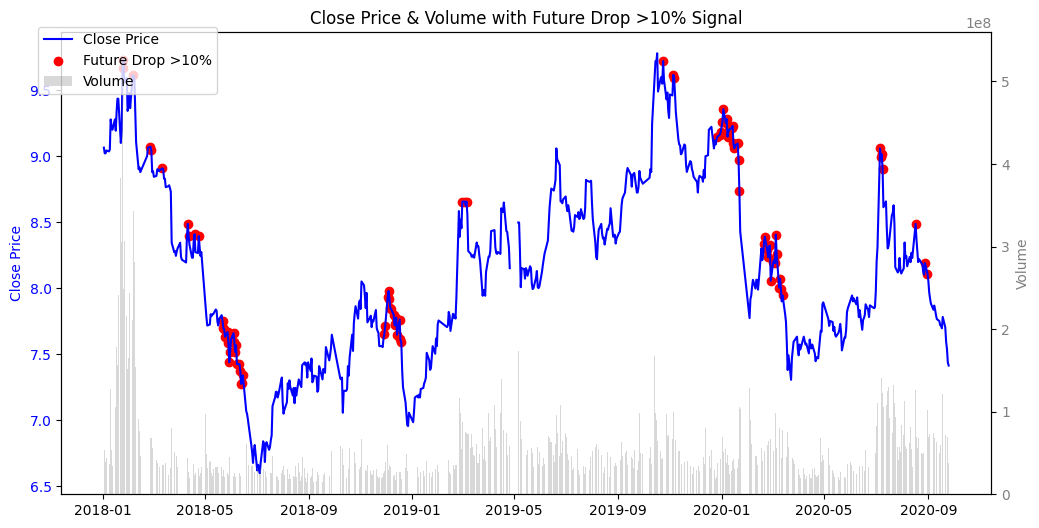

In [111]:
fig, ax1 = plt.subplots(figsize=(12,6))

# 收盘价曲线
ax1.plot(df.index, df["$close"], label="Close Price", color="blue")

# 标记未来会下跌10%的点
mask = df["drop_10pct_next_month"] == 1
ax1.scatter(df.index[mask], df["$close"][mask],
           color="red", label="Future Drop >10%", marker="o")

ax1.set_title("Close Price & Volume with Future Drop >10% Signal")
ax1.set_ylabel("Close Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 成交量放在副轴
ax2 = ax1.twinx()
ax2.bar(df.index, df["$volume"], alpha=0.3, color="gray", label="Volume")
ax2.set_ylabel("Volume", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# 图例
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()


## 相关性

drop_10pct_next_month         1.000000
$close                        0.121251
$volume                       0.080801
($high-$low)/$close           0.041996
Mean($volume, 5)              0.022000
Std($close, 10)              -0.014975
Mean($close, 5)/$close - 1   -0.079171
Ref($close, -1)/$close - 1   -0.144855
future_min_20d               -0.239722
max_drop_pct_20d             -0.760200
Name: drop_10pct_next_month, dtype: float64


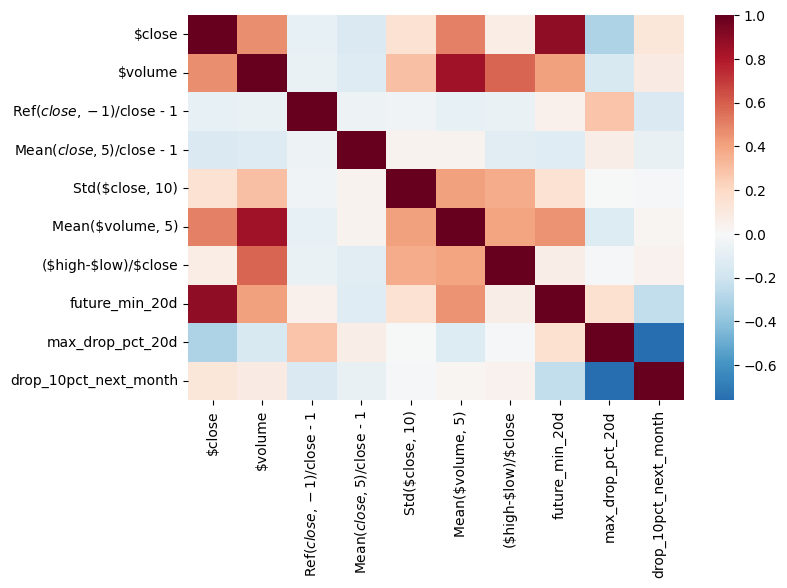

In [113]:

import matplotlib.pyplot as plt

corr = df.corr()["drop_10pct_next_month"].sort_values(ascending=False)
print(corr)

# 可视化相关性热力图
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), cmap="RdBu_r", center=0)
plt.show()


## 可预测性

### 1. 训练模型，打印AUC值

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = df.drop(columns=["drop_10pct_next_month","future_min_20d","max_drop_pct_20d"])
y = df["drop_10pct_next_month"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:,1]

print("AUC:", roc_auc_score(y_test, y_pred))


AUC: 0.33483231707317074


### 2. 绘制 ROC 曲线

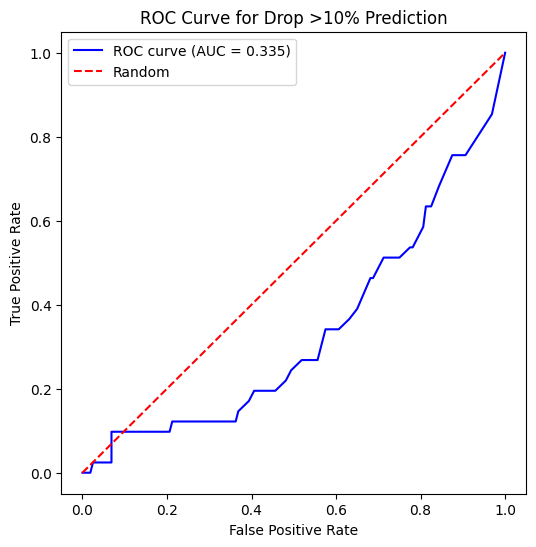

In [115]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Drop >10% Prediction')
plt.legend()
plt.show()

### 3. 绘制预测概率分布

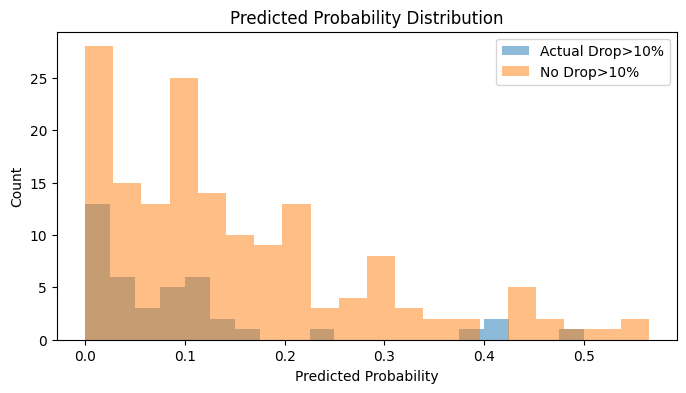

In [116]:
plt.figure(figsize=(8,4))
plt.hist(y_pred[y_test==1], bins=20, alpha=0.5, label='Actual Drop>10%')
plt.hist(y_pred[y_test==0], bins=20, alpha=0.5, label='No Drop>10%')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Predicted Probability Distribution')
plt.legend()
plt.show()


* **x轴**：模型预测概率（预测未来20天跌超10%的概率，0\~1）
* **y轴**：样本数（每个预测概率范围内的样本数量）
* **两条直方图**：

  * `Actual Drop>10%`（真实为1） → 红色（或你设的颜色）
  * `No Drop>10%`（真实为0） → 蓝色（或你设的颜色）

1. **区分度**

   * 理想情况：

     * `Actual Drop>10%`（1） → 高概率集中在靠右（接近1）
     * `No Drop>10%`（0） → 低概率集中在靠左（接近0）
   * 如果两类直方图重叠严重 → 模型区分能力差，预测不靠谱

2. **概率大小**

   * 高峰在 0.5 附近 → 模型预测偏随机
   * 高峰在 0 或 1 附近 → 模型比较自信

3. **类别不平衡影响**

   * 如果跌幅事件很稀少（大多数 y=0），蓝色柱子会远高于红色柱子
   * 需要结合概率阈值（如 >0.6）来判断策略信号，而不是简单用 0.5

4. **模型调整**

   * 如果分布严重偏向某一端，说明模型预测概率偏向主类（比如大多数预测接近0）
   * 可以考虑：

     * 使用 class\_weight=“balanced”
     * 或用更强模型 / 特征工程

---

### 3️⃣ 小结

* 直方图主要告诉你 **预测概率和真实标签的匹配情况**
* 如果两类概率分布明显分开 → 模型有效
* 如果分布重叠 → 模型区分能力低，需要改进因子或模型


### 4. 预测

In [137]:
# 加载一段时间的数据
df = D.features(
    instruments=["SZ000001"],
    fields=[
        "$close", "$volume",
        "Ref($close, -1)/$close - 1",       # 昨日收益率
        "Mean($close, 5)/$close - 1",       # 5日动量
        "Std($close, 10)",                  # 10日波动率
        "Mean($volume, 5)",                 # 5日均量
        "($high-$low)/$close",              # 日内波动率
    ],
    start_time="2018-01-01",
    end_time="2020-12-31",
    freq="day"                      # 日频
)

In [118]:
df.tail()

$close      $volume  Ref($close, -1)/$close - 1  \
instrument datetime                                                        
SZ000001   2020-09-21  3.297979  426126592.0                   -0.015180   
           2020-09-22  3.247915  413580128.0                    0.004496   
           2020-09-23  3.262517  285060896.0                   -0.031969   
           2020-09-24  3.158217  501213952.0                    0.002642   
           2020-09-25  3.166561  291365728.0                         NaN   

                       Mean($close, 5)/$close - 1  Std($close, 10)  \
instrument datetime                                                  
SZ000001   2020-09-21                   -0.010626         0.062310   
           2020-09-22                    0.007450         0.062619   
           2020-09-23                    0.005627         0.061464   
           2020-09-24                    0.033554         0.065397   
           2020-09-25                    0.018972         0.060532   

                       Mean($volume, 5)  ($high-$low)/$close  
instrument datetime                                           
SZ000001   2020-09-21       435776320.0             0.021505  
           2020-09-22       456278720.0             0.028902  
           2020-09-23       444665696.0             0.020460  
           2020-09-24       450965344.0             0.032365  
           2020-09-25       383469472.0             0.013175

In [119]:
# 假设 clf 已训练好
X_today = df.loc[("SZ000001", "2020-09-25")].to_frame().T  # 最新一天的一行因子

y_pred_proba = clf.predict_proba(X_today)[:,1]  # 概率
y_pred_label = clf.predict(X_today)             # 类别 0/1

print("预测概率:", y_pred_proba)
print("预测类别:", y_pred_label)


预测概率: [0.185]
预测类别: [0]


## 自动寻找相关性高的因子

In [126]:
from qlib.contrib.data.handler import Alpha158, Alpha360
alpha158_factors = .fields
print(alpha158_factors[:10])  # 前10个因子名

[8272:MainThread](2025-08-29 16:16:01,720) INFO - qlib.timer - [log.py:127] - Time cost: 27.063s | Loading data Done
[8272:MainThread](2025-08-29 16:16:02,747) INFO - qlib.timer - [log.py:127] - Time cost: 0.213s | DropnaLabel Done
[8272:MainThread](2025-08-29 16:16:03,646) INFO - qlib.timer - [log.py:127] - Time cost: 0.899s | CSZScoreNorm Done
[8272:MainThread](2025-08-29 16:16:03,656) INFO - qlib.timer - [log.py:127] - Time cost: 1.935s | fit & process data Done
[8272:MainThread](2025-08-29 16:16:03,656) INFO - qlib.timer - [log.py:127] - Time cost: 29.000s | Init data Done


AttributeError: 'Alpha158' object has no attribute 'fields'

In [127]:
a=Alpha158()

[8272:MainThread](2025-08-29 16:17:04,511) INFO - qlib.timer - [log.py:127] - Time cost: 27.413s | Loading data Done
[8272:MainThread](2025-08-29 16:17:05,633) INFO - qlib.timer - [log.py:127] - Time cost: 0.187s | DropnaLabel Done
[8272:MainThread](2025-08-29 16:17:06,555) INFO - qlib.timer - [log.py:127] - Time cost: 0.920s | CSZScoreNorm Done
[8272:MainThread](2025-08-29 16:17:06,567) INFO - qlib.timer - [log.py:127] - Time cost: 2.056s | fit & process data Done
[8272:MainThread](2025-08-29 16:17:06,568) INFO - qlib.timer - [log.py:127] - Time cost: 29.470s | Init data Done


In [136]:
a.get_feature_names()

AttributeError: 'Alpha158' object has no attribute 'get_feature_names'